# Изучение связи между электронной концентрацией на фиксированных ионосферных высотах и уровнем освещенности

### Описание задачи
В рассматриваемой задаче исследуются данные электронной концентрации в ионосфере над Красным морем в период с 24 ноября по 1 декабря 2015г. полученные радиозатменным методом на трассе GPS-LEO. Получены зависимости электронной концентрации от локального времени для выделенных высот в окрестности 20 км от 100 до 400 км с шагом 50 км. Работа выполнена в рамках Программы Президиума РАН №12, шифр «Волга» «Радиофизические исследования процессов распространения радиоволн для изучения солнечно-земных связей, околосолнечной плазмы, атмосфер, ионосфер и грунта планет и малых тел Солнечной системы» в 2020г.



In [ ]:
Исходные данные:
1. Результаты IonPrf в 26 сеансах измерений COSMIC/GPS IonPrf на высотах 80-1000км с шагом 1 секунда между соседними точкаи.
2. Высота точки над уровнем мирового океана, ее широта и долгота, значение электронной концентрации - количества свободных электронов в кубическом сантиметре.


In [ ]:
Необходимо:
    Найти связь между уровнем освещенности и концентрацией свободных носителей заряда на высотах от 100 до 400км.

### Загрузка необходимых библиотек

In [ ]:
%matplotlib inline

import numpy
import sys
import os
from os import walk
import netCDF4

from functools import reduce

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
%matplotlib inline
from sunposition import sunpos
import datetime
from datetime import date
import math

## Часть 1. Подготовка загрузки данных в формате netcdf

In [ ]:
alt_groups_cfg = [ 100, 150, 200, 250, 300, 350, 400 ]
ALT_RADIUS = 20

def openFile(path='', mode='r'):
    try:
        nc = netCDF4.Dataset(path, mode='r', format='NETCDF3_CLASSIC')
        return nc
    except Exception as e:
        raise NetCDFError('An error occured while opening the NetCDF file "%s": %s' % (path,str(e)))

result_data =  [
        {
            'season': 0,
            'year': 2015,
            'all': [],
            'avg_elec_dens': 0,
            'alt': 120,
            'alt_step': 5,
            'alt_groups': []
        }
    ]

class InvalidDirectoryException(Exception):
    """Exception raised when invalid year/day directory passed"""
    pass

def getNextFile(year = "", str_day = ""):

    dfn = "kras333/" 
    dname = dfn + str(year) + "." + str_day

    if( not os.path.exists(dname)):
        print('Error directory: ', dname)
 
    fnames = [f for f in listdir(dname) if isfile(join(dname, f))]
    count = 0

    while (count < len(fnames)):

        ffn = dname + "/" + fnames[count] 
        data = openFile(path = dname + "/" + fnames[count] , mode = "r")   
       
        result = {
            'data': data,
            'utc_time_hour': fnames[count][21:23],
            'utc_time_minutes': fnames[count][24:26],
            'filename': fnames[count],
            'directory': dfn,
            'fname': ffn,
            'filenumber': count,
            'totalfiles': len(fnames)
        }
        count +=1
        yield result

## Часть 2. Загрузка и анализ ионосферных данных

generator Stopped


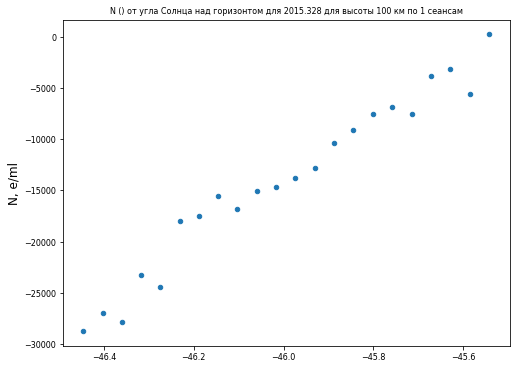

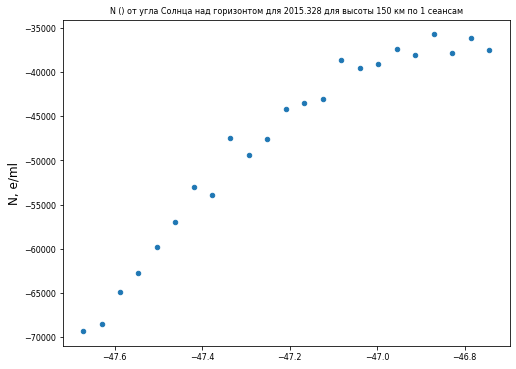

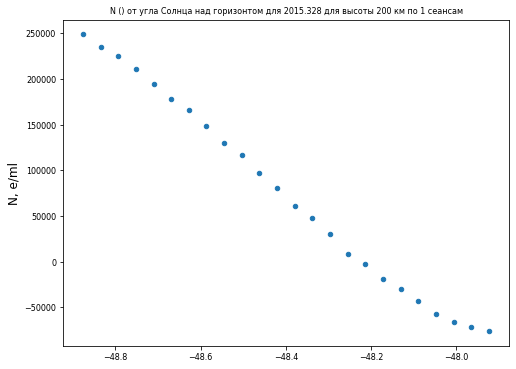

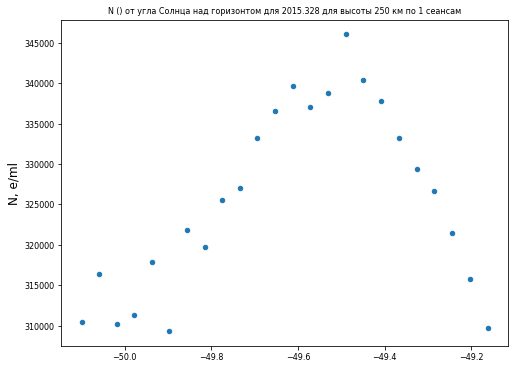

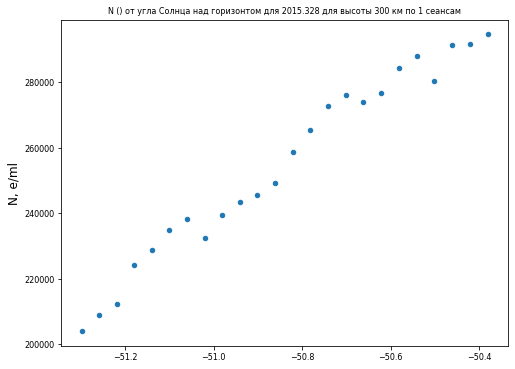

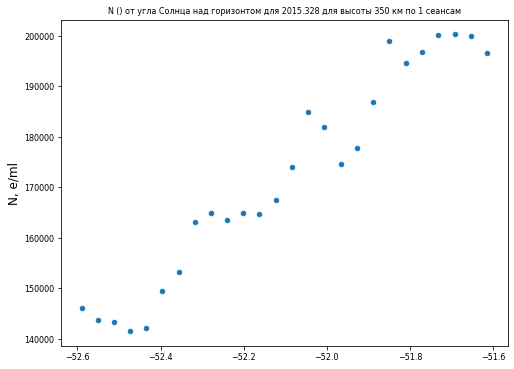

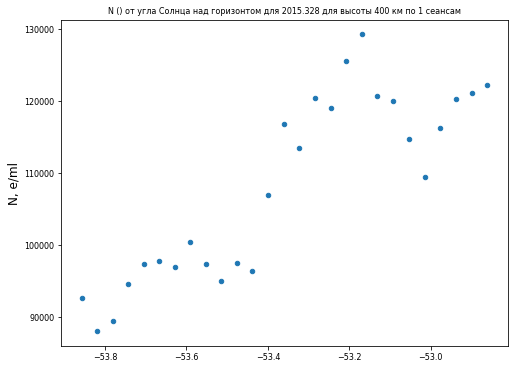

generator Stopped


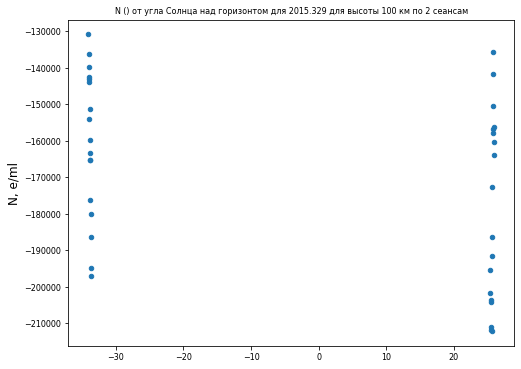

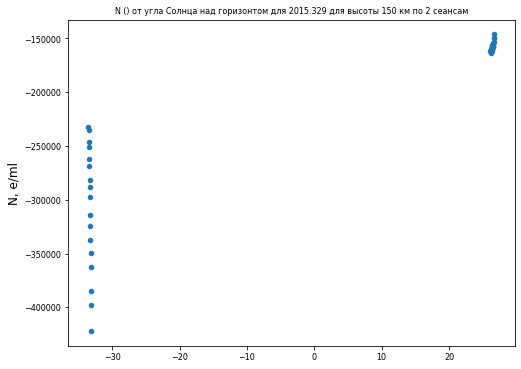

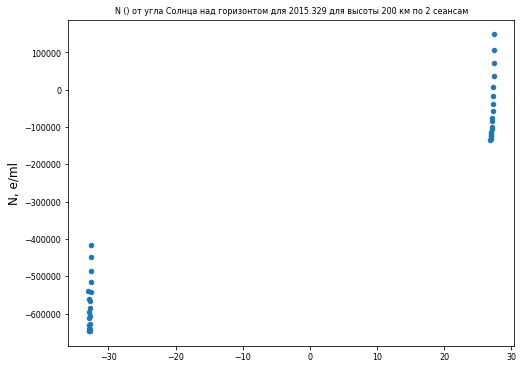

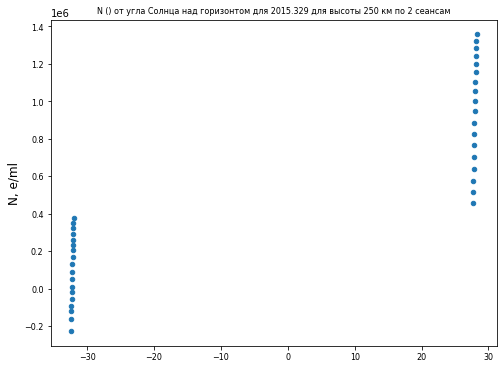

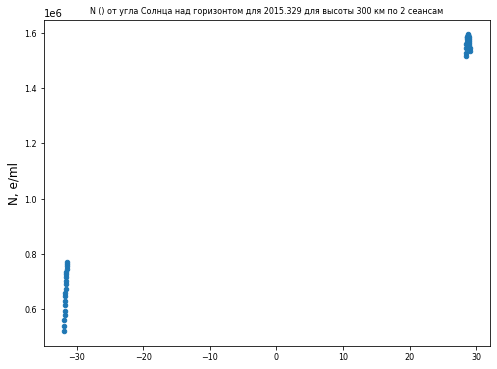

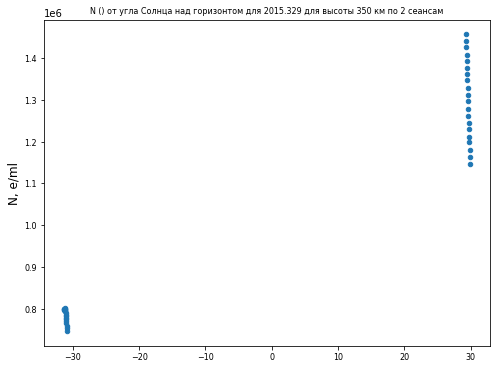

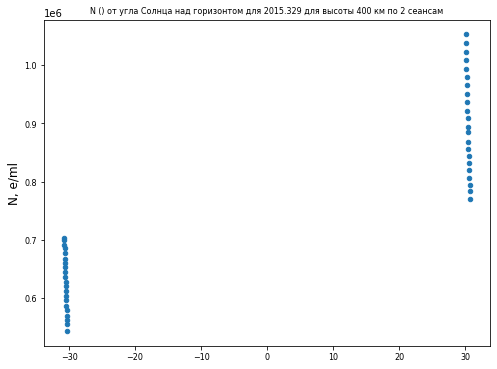

generator Stopped


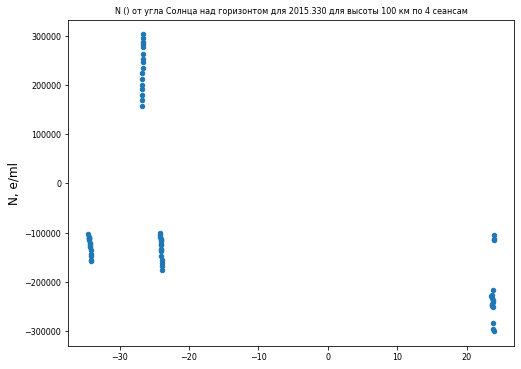

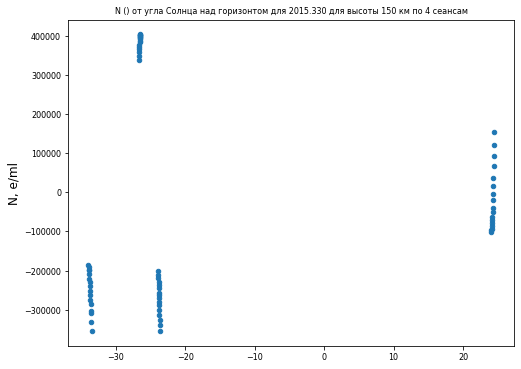

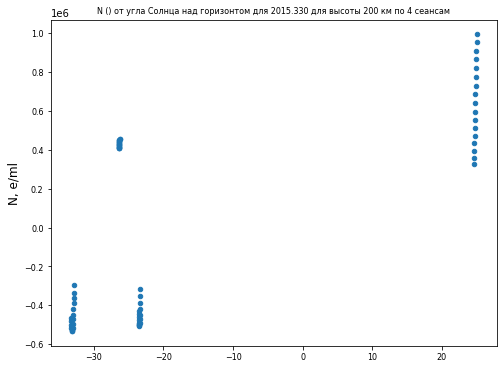

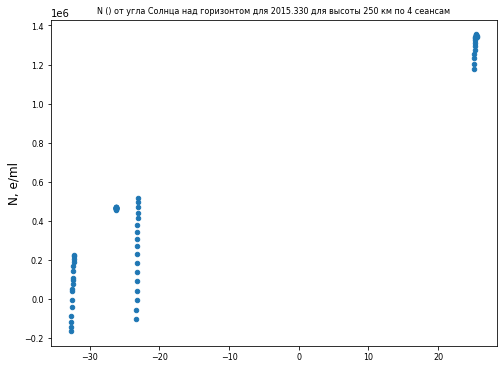

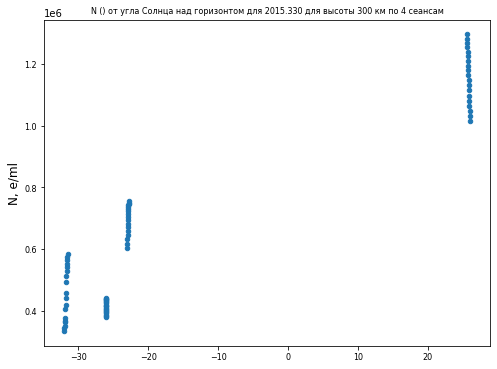

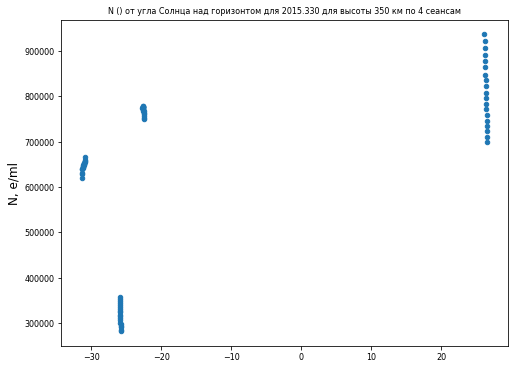

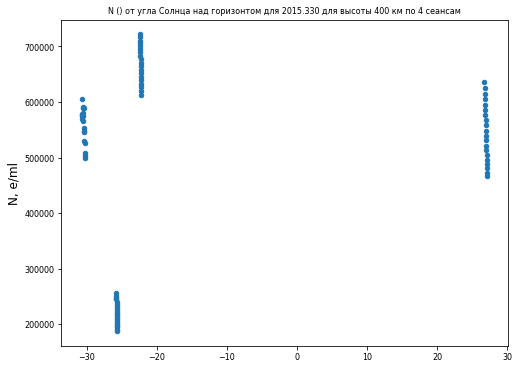

In [ ]:
        
def readDirFiles():
    global result_data

    year = 2015
    day = 328
    Done = False

    
    while( year < 2020 and day < 335):


        str_day = str(day)
        if (day < 10):
            str_day = "00" + str(day)
        elif(day < 100): 
            str_day = "0" + str(day)

        generator = getNextFile(year = year, str_day = str_day)

        if (Done) :
            break

        if ( year % 4 == 0 and day == 366 or year % 4 != 0 and day == 365):
            year +=1
            day = 1
        elif (year % 4 == 0 and day < 366):
            day += 1
        elif (day < 365):
            day += 1


        result_values = [ r for r in result_data if r['year'] == year ]
        result_value = result_values[0] if (len(result_values) > 0) else None

        if ( not (result_value )):
            
            result_value = {

                'year': year,
                'alt_groups': []
                
            }
            result_data.append(result_value)

        
        day_data = {
            'year': year,
            'day': day,
            'alt_groups': [],
            'all_dens': [],
            'all_tecs': [],
            'all_ltimes':[],
            'all_heights':[]
        }


        while True:
            try:
                data = next(generator) 
                local_time = int(data['utc_time_hour']) + (1/60) * int(data['utc_time_minutes'])

                for  i in range (len(data['data'].variables["MSL_alt"]))  : 

                    if ((data['data'].variables["MSL_alt"][i] > 50) and (data['data'].variables["MSL_alt"][i] < 650)) :

                        altInRange = False
                        resAlt = 0

                        for alt in alt_groups_cfg:
                            if(( data['data'].variables["MSL_alt"][i] < alt + ALT_RADIUS ) and ( data['data'].variables["MSL_alt"][i] > alt - ALT_RADIUS)   ) :
                                altInRange = True
                                resAlt = alt 

                        if ( altInRange ):

                            hasAltGroups = [ a for a in result_value['alt_groups'] if ('alt' in a) and a['alt'] == resAlt ]

                            altGroup = hasAltGroups[0] if len(hasAltGroups) > 0 else None

                            if ( not altGroup ):
                                altGroup = {
                                    'alt': resAlt,
                                    'avg_elec_dens': 0,
                                    'avg_tecs': 0,
                                    'all_dens': [],
                                    'all_tecs': [],
                                    'all_ltimes':[],
                                    'all_heights':[],
                                    'all_zens': []
                                }
                                result_value['alt_groups'].append(altGroup)


                            hasAltGroupsDay = [ a for a in day_data['alt_groups'] if ('alt' in a) and a['alt'] == resAlt ]

                            altGroupDay = hasAltGroupsDay[0] if len(hasAltGroupsDay) > 0 else None

                            if ( not altGroupDay):
                                altGroupDay = {
                                    'alt': resAlt,
                                    'avg_elec_dens': 0,
                                    'avg_tecs': 0,
                                    'all_dens': [],
                                    'all_tecs': [],
                                    'all_ltimes':[],
                                    'all_heights':[],
                                    'all_zens': [],
                                    'filenumber': data['totalfiles']
                                }
                                day_data['alt_groups'].append(altGroupDay) 
                            
                            if (True):

                                loc_time = local_time + (1/15)*data['data'].variables["GEO_lon"][i]
                                if (loc_time>24) :  
                                    loc_time = loc_time - 24


                                LON = data['data'].variables["GEO_lon"][i]
                                LAT = data['data'].variables["GEO_lat"][i]
                                hourlocal = int(data['utc_time_hour'])
                             
                                minLocal = int(data['utc_time_minutes'])
                              
                                
                                d0 = date(1970, 1, 1)
                                d1 = date(year, 1, 1)
                                dayss = (d1-d0)
                               
                                datem1=datetime.datetime.fromordinal(dayss.days)
                                yearLocal = int(year)
                               
                                now = datetime.datetime(year=yearLocal, month=int(datem1.month), day=int(datem1.day), hour=hourlocal, minute=minLocal, second=0, microsecond=0, tzinfo=None) 
                                az,zen = sunpos(now,LAT,LON,0)[:2]  

                                elev = 90 - zen

                                #print('Year,month,day, lat, lon, sunpos ',now,LAT,LON,elev)

                                altGroup['all_dens'].append( data['data'].variables["ELEC_dens"][i] )
                                altGroup['all_tecs'].append( data['data'].variables["TEC_cal"][i] )
                                altGroup['all_heights'].append( data['data'].variables["MSL_alt"][i] )
                                altGroup['all_ltimes'].append(loc_time)
                                altGroup['all_zens'].append(elev)

                                altGroupDay['all_dens'].append( data['data'].variables["ELEC_dens"][i] )
                                altGroupDay['all_tecs'].append( data['data'].variables["TEC_cal"][i] )
                                altGroupDay['all_heights'].append( data['data'].variables["MSL_alt"][i] )
                                altGroupDay['all_ltimes'].append(loc_time)
                                altGroupDay['all_zens'].append(elev)
                                #print('Средняя электронная концентрация для высоты', resAlt, ' км ', sum(altGroup['all_dens']) / len(altGroup['all_dens']) )
                                #print('Локальное время = ', loc_time, ' для высоты = ', data['data'].variables["MSL_alt"][i])


            except InvalidDirectoryException:
                print('generator Stopped with Invalid directory')
                Done = True
                break

            except StopIteration:
                print('generator Stopped')
                #Done = True
                break

            except Exception as e:
                print('generator Exception : ', e)
                #Done = True
                break

        
        
        for gr in day_data['alt_groups']:
            
            if ( len (gr['all_dens']) or len(gr['all_tecs']) > 0):
                ind_alt = day_data['alt_groups']
                fig, ax = plt.subplots( nrows = 1, ncols = 1, figsize = (8,6) )  
          
                ax.scatter(gr['all_zens'], gr['all_dens'], s=80, c='tab:blue', marker=".")
            

                
                l1 = len(gr['all_zens'])
                new_tzen = []
                j = 0 
                while (j< l1) :
                    new_tzen.append( math.sin((gr['all_zens'][j])/180*math.pi))
                    j += 1
                    
                k_corr = numpy.corrcoef(new_tzen,gr['all_dens'])[0][1]
                #print( 'array lengths', len(gr['all_zens']), len(gr['all_dens']), len(new_tzen))

                box = dict( pad=10, alpha=0)
                #ax.set_xlabel('Коэфф. корреляции Ne, sin(Sun Altitude) = ' + str(k_corr)+ ' кол-во точек '+str(len(gr['all_zens'])), fontsize=32, bbox = box)
                ax.set_ylabel('N, e/ml', fontsize=12)
                ax.set_title('N () от угла Солнца над горизонтом для '+str(day_data['year'])+'.'+str(day_data['day']-1)+' для высоты '+str(gr['alt'])+' км по '+str(gr['filenumber'])+' сеансам', bbox = box, fontsize=8)

                for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(8) 
                for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(8) 

            plt.show()

readDirFiles()
        

## Часть 3. Выводы

1. Реализована последовательная загрузка сеансов радиопросвечивания NetCDF4 по данным COSMIC/GPS. Обнаружены сеансы с коэффициентом корреляции синуса угла Солнца над горизонтом и электронной концентрации >0.9.
   
2. Построены графики зависимости электронной концентрации от угла Солнца над горизонтом для высот 100, 150, 200, 250, 300, 350, 400 км
3. Обнаружены аномальные значения электронной концентрации >10^6 эл/см3 , что говорит об ионосферных возмущениях.